# Part V: XAI with SHAP

## Basic settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import json
import os
import pickle
import sys
import warnings
from datetime import datetime, timedelta

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")

# Set random seed for reproducibility
np.random.seed(2025)

c:\Users\tiamo\anaconda3\envs\aio_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
src_path = os.path.abspath(os.path.join("..", "src"))
if src_path not in sys.path:
    sys.path.append(src_path)

In [5]:
from utils.utils import load_model
from utils.plots import plot_sales_predictions

In [6]:
DATA_DIR = "../data"
SALES_DATA_PATH = os.path.join(DATA_DIR, "feature_engineered_data_55_features.feather")

## Load data and pre-trained model

In [7]:
df_features = pd.read_feather(SALES_DATA_PATH)

In [8]:
# Drop unnecessary columns
cols_to_drop = [
    "date",
    "province",
    "store_name",
    "item_name",
    "store_item",
    "is_test",
    "category",
]

# Split features and target, and separate train/test
X_train = df_features[~df_features["is_test"]].drop(cols_to_drop + ["sales"], axis=1)
y_train = df_features[~df_features["is_test"]]["sales"]

X_test = df_features[df_features["is_test"]].drop(cols_to_drop + ["sales"], axis=1)
y_test = df_features[df_features["is_test"]]["sales"]

In [9]:
model_path = f"../models/sales_forecast_model.pkl"
optimized_model = load_model(model_path)

Sklearn model loaded from ../models/sales_forecast_model.pkl


In [10]:
assert os.path.exists(model_path), f"Missing model: {model_path}"

In [11]:
# Load light GBM model
optimized_model = load_model(model_path)

Sklearn model loaded from ../models/sales_forecast_model.pkl


In [12]:
optimized_model

,boosting_type,'gbdt'
,num_leaves,33
,max_depth,-1
,learning_rate,0.03787277782280418
,n_estimators,100
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,26


## Prediction and evaluation

In [13]:
test_results = df_features[df_features["is_test"]].copy()
test_results["prediction"] = optimized_model.predict(X_test)
test_results["error"] = test_results["sales"] - test_results["prediction"]
test_results["abs_error"] = np.abs(test_results["error"])
df_prediction = test_results[
    ["date", "store_id", "store_name", "category", "item_id", "item_name", "sales", "prediction"]
]

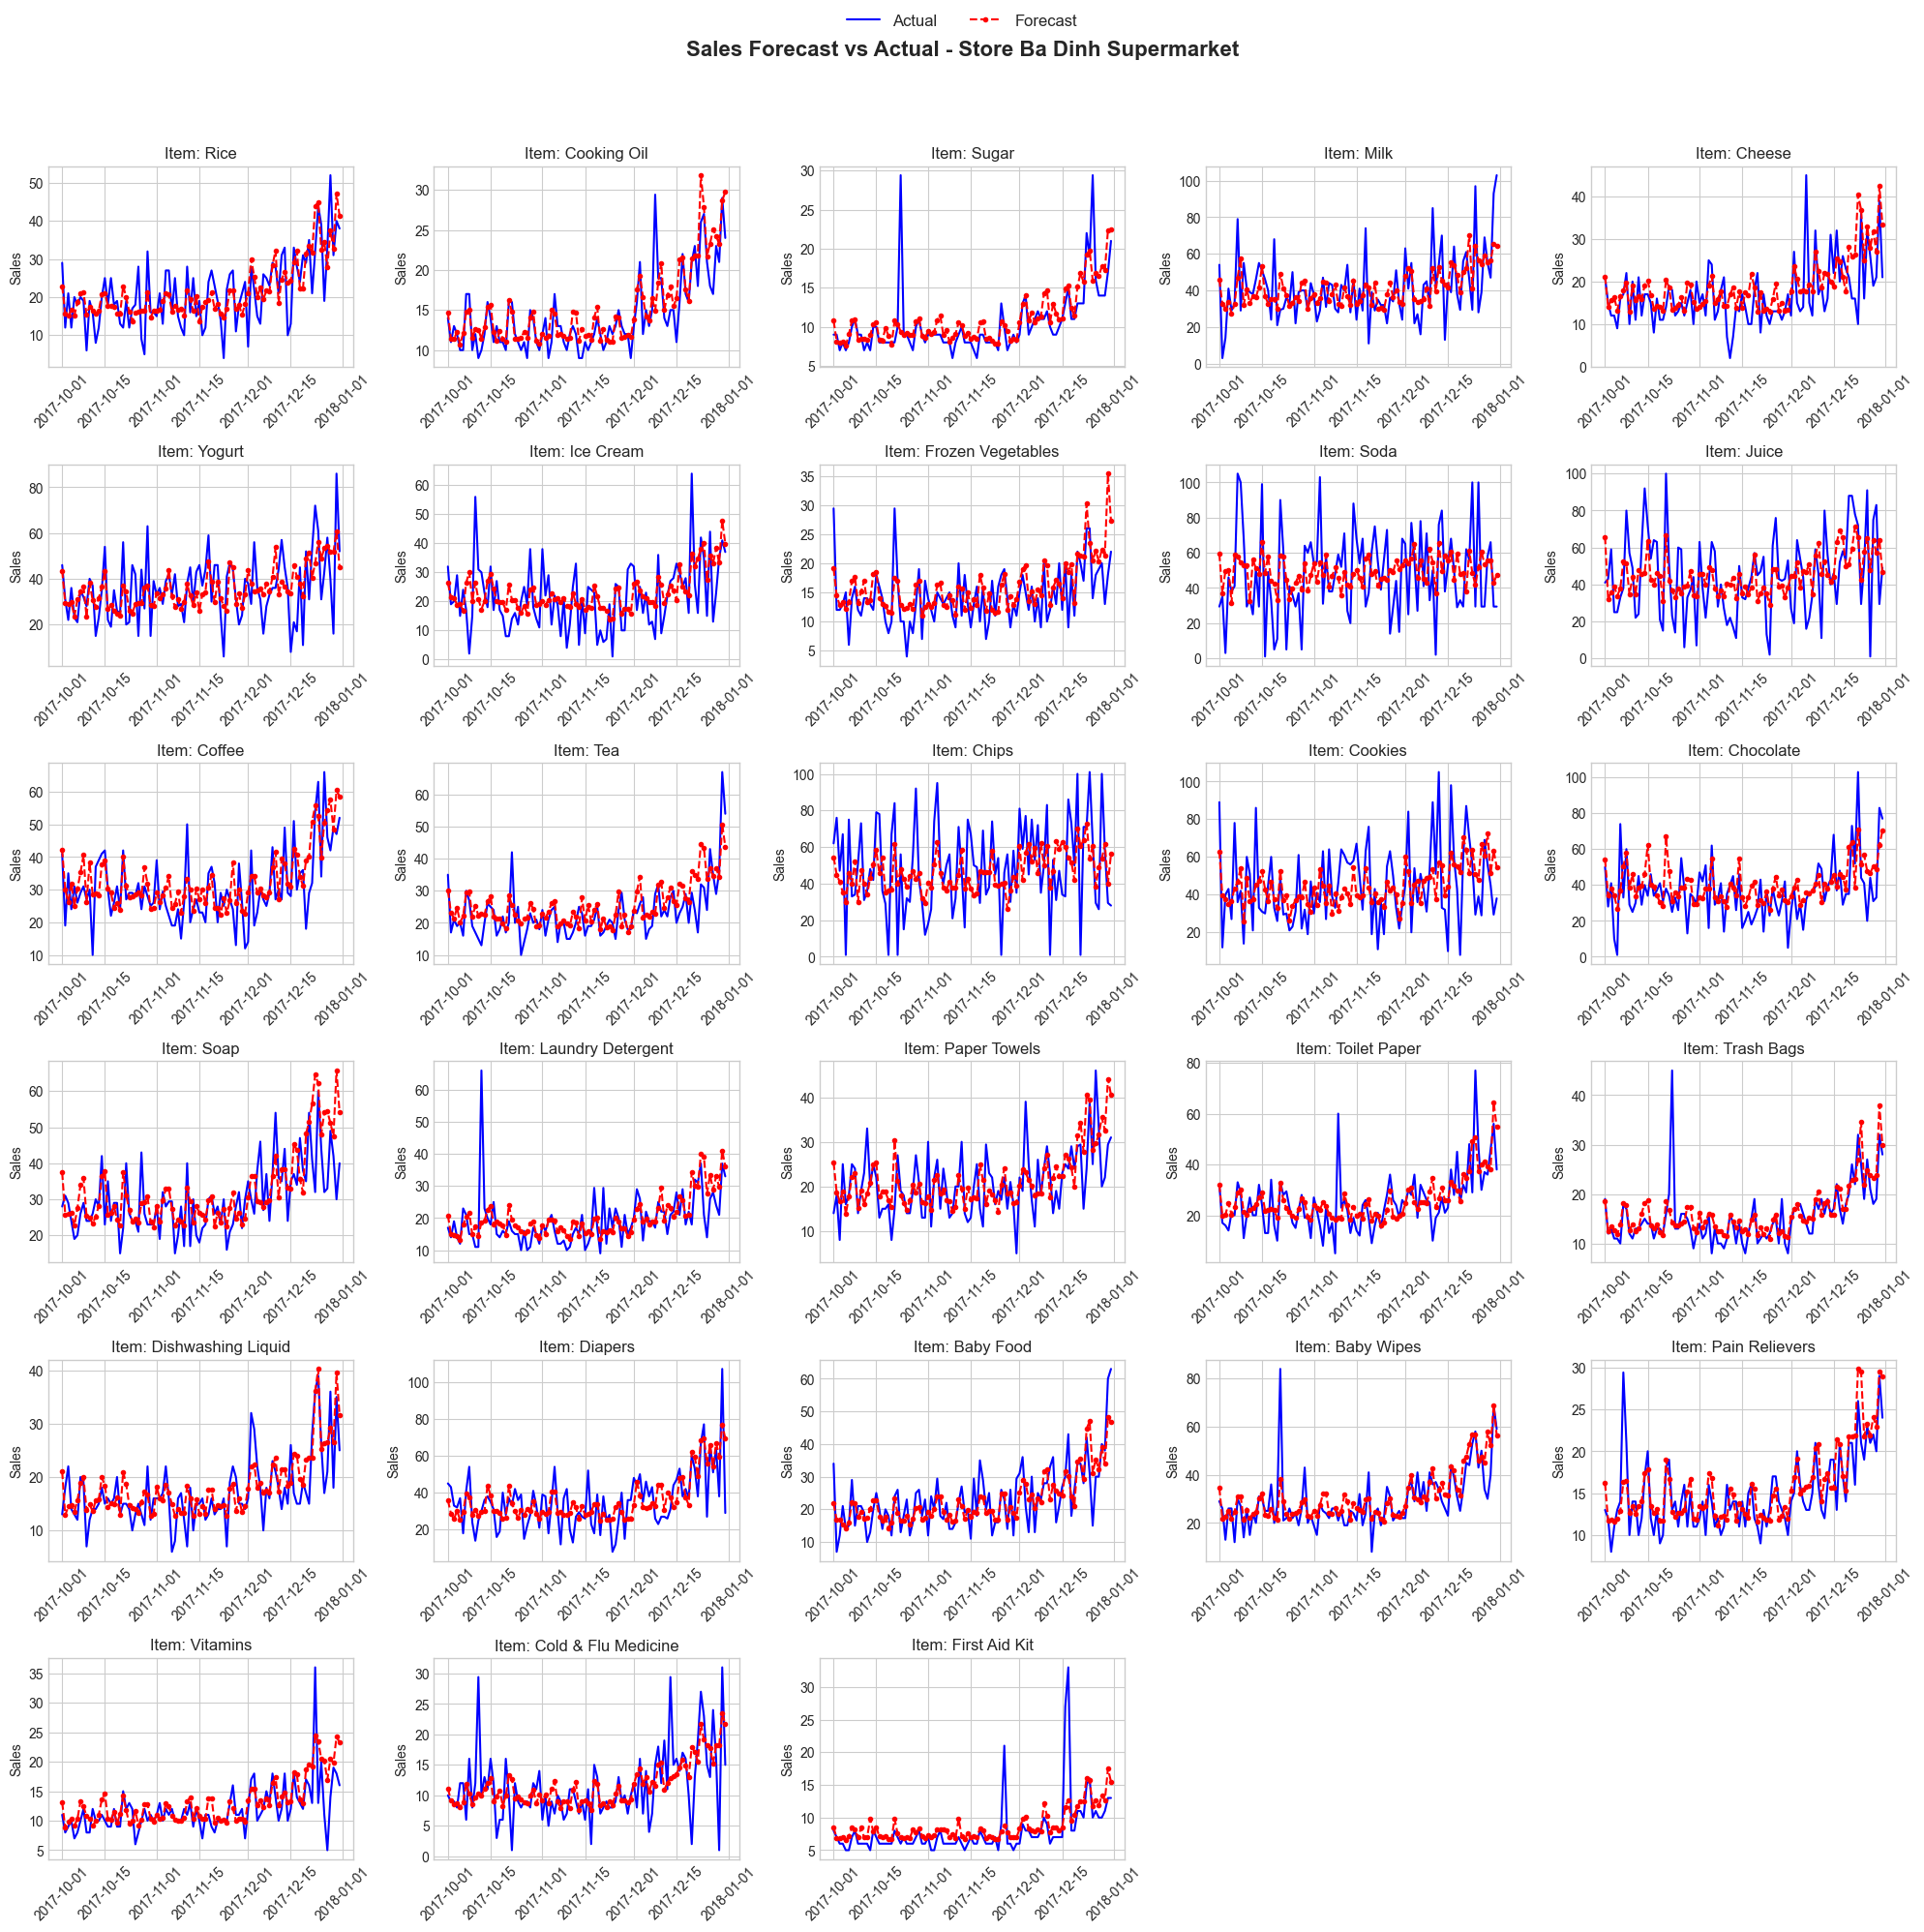

In [14]:
# Plot the prediction
store_id = 2
plot_sales_predictions(df_prediction, store_id=store_id)

## Explainable AI - SHAP

### Calculated SHAP values

In [15]:
# Use samples from both training and test sets
X_train_sample = X_train.sample(min(500, len(X_train)), random_state=42)
X_test_sample = X_test.sample(min(500, len(X_test)), random_state=42)
X_sample = pd.concat([X_train_sample, X_test_sample])

In [16]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(optimized_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

### Global feature importance

Top 10 most important features globally:
       feature  importance
  item_mean_7d    7.366415
sales_mean_28d    3.339039
 store_mean_7d    1.722238
sales_mean_14d    1.258279
  store_sum_7d    1.137457
 sales_mean_7d    0.707108
      store_id    0.454826
         month    0.399888
   item_sum_7d    0.340344
   day_of_week    0.177952


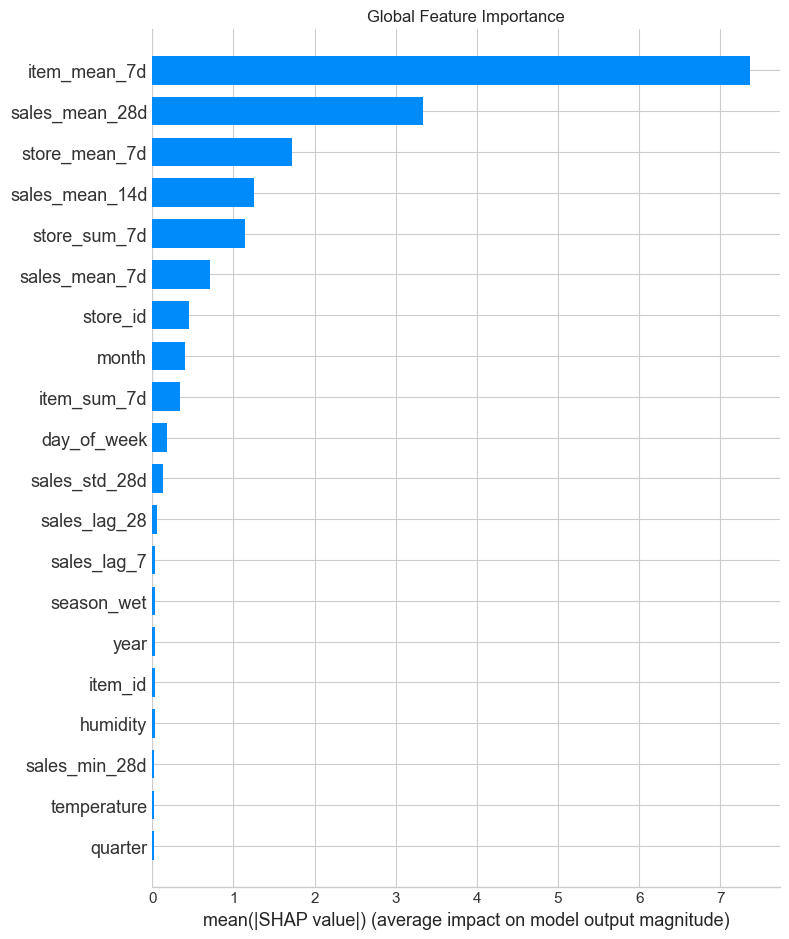

In [17]:
# Global feature importance
print("Top 10 most important features globally:")
feature_importance = pd.DataFrame(
    {"feature": X_sample.columns, "importance": np.abs(shap_values).mean(axis=0)}
)
feature_importance = feature_importance.sort_values("importance", ascending=False)
print(feature_importance.head(10).to_string(index=False))

# Global feature importance plot
plt.figure(figsize=(14, 8))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("Global Feature Importance")
plt.tight_layout()

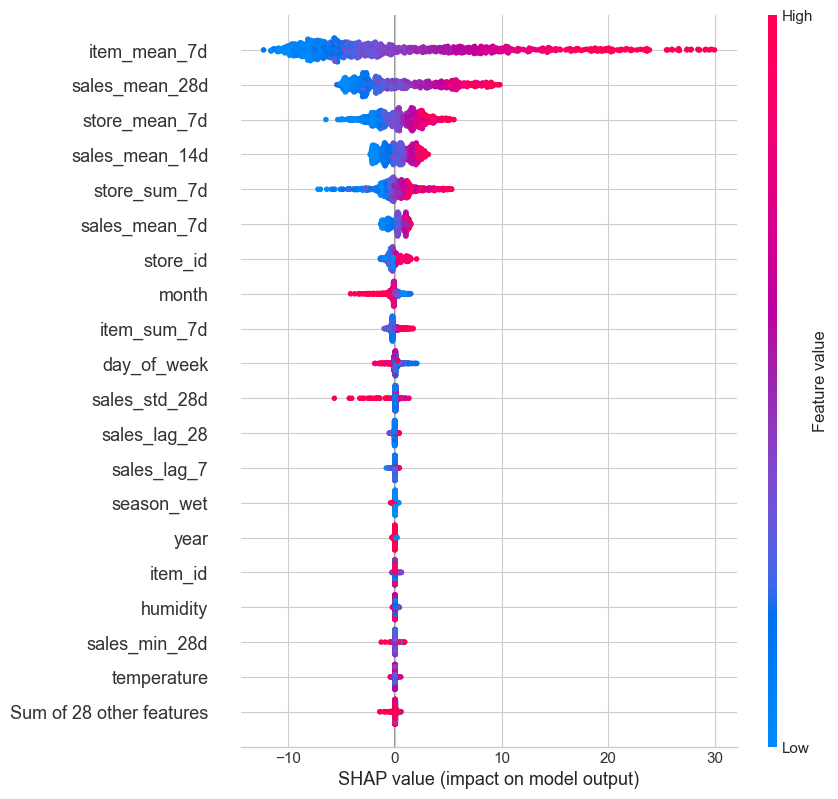

In [18]:
# Summarize the effects of all the features
shap.plots.beeswarm(explainer(X_sample), max_display=20)

* **Top 5 most influential features**

  * `item_mean_7d`: the average sales of the product over the past 7 days. A product that has sold well recently (7 days) is an optimistic signal for continued strong performance.

    * High values (red) → positive SHAP value → prediction increases.
    * Low values (blue) → negative SHAP value → prediction decreases.
  * `sales_mean_28d`: the 28-day average sales — a stable product over the month strongly impacts the prediction.
  * `store_mean_7d`: the average sales of the store over the past 7 days — recent store performance — if the store is performing well, the model predicts higher sales.
  * `sales_mean_14d`: captures recent sales trends — combining short- and medium-term (2-week) trends to support more accurate forecasts.
  * `store_sum_7d`: total sales volume of the store over 7 days — helps understand demand at each point of sale.
  * `store_id`, `item_id`: may reflect the specific influence of each store or product.
  * `season_wet`, `temperature`: weather factors also have an impact.

---

* **Key observation:**

  * The model is highly sensitive to recent sales trends (averages, totals, standard deviations).
  * Features like `item_mean_7d` and `sales_mean_28d` have the strongest influence on the model's decisions.


### Dependency Plots

In [19]:
shap_values_valid = explainer(X_sample)

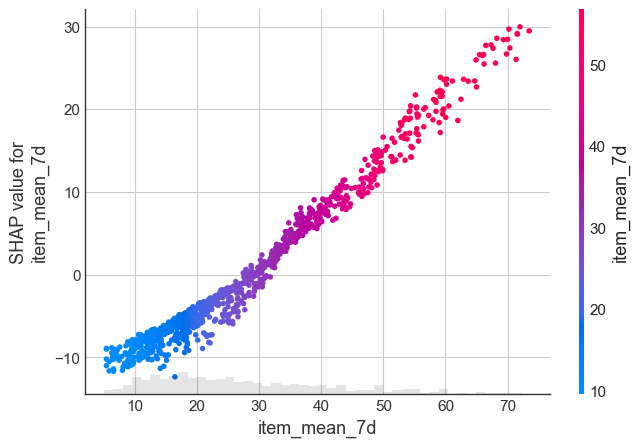

In [20]:
# SHAP dependency plots for top features
feature_name = "item_mean_7d"
shap.plots.scatter(shap_values_valid[:, feature_name], color=shap_values_valid[:, feature_name])

**1. Observations:**

* The chart shows an almost linear positive relationship between `item_mean_7d` and the SHAP value.
* As the 7-day average sales increase, the impact of this feature on the prediction clearly increases.
* This confirms that if a product has sold well recently, the model will likely forecast higher future sales.

**2. Impact threshold:**

* When `item_mean_7d` < 20 → SHAP values are usually negative → the model lowers the sales prediction.
* When `item_mean_7d` > 30 → SHAP values are positive and increase sharply → the model raises the prediction significantly.
* Suggestion: 30 could serve as a “business threshold” to segment fast-selling products.

### Local explanations


Local explanation for 2017-10-26, Store: Ba Dinh Supermarket, Item: Juice
Actual sales: 59.00, Predicted: 35.44
Top factors increasing the prediction:
       feature   effect
  item_mean_7d 8.418831
sales_mean_28d 4.946372
sales_mean_14d 1.684944
 sales_mean_7d 0.863002
   item_sum_7d 0.402062
Top factors decreasing the prediction:
      feature    effect
 store_sum_7d -4.098748
store_mean_7d -2.398635
        month -0.632001
     store_id -0.389455
         year -0.117062

Local explanation for 2017-12-08, Store: Tay Ho Store, Item: Vitamins
Actual sales: 14.00, Predicted: 15.22
Top factors increasing the prediction:
           feature   effect
     store_mean_7d 1.322847
      store_sum_7d 0.604107
     sales_std_28d 0.029990
          humidity 0.016614
sales_ewma_7d_a075 0.011534
Top factors decreasing the prediction:
       feature    effect
  item_mean_7d -7.627161
sales_mean_28d -3.206387
sales_mean_14d -1.001786
 sales_mean_7d -0.432509
      store_id -0.415818

Local explanati

<Figure size 1200x300 with 0 Axes>

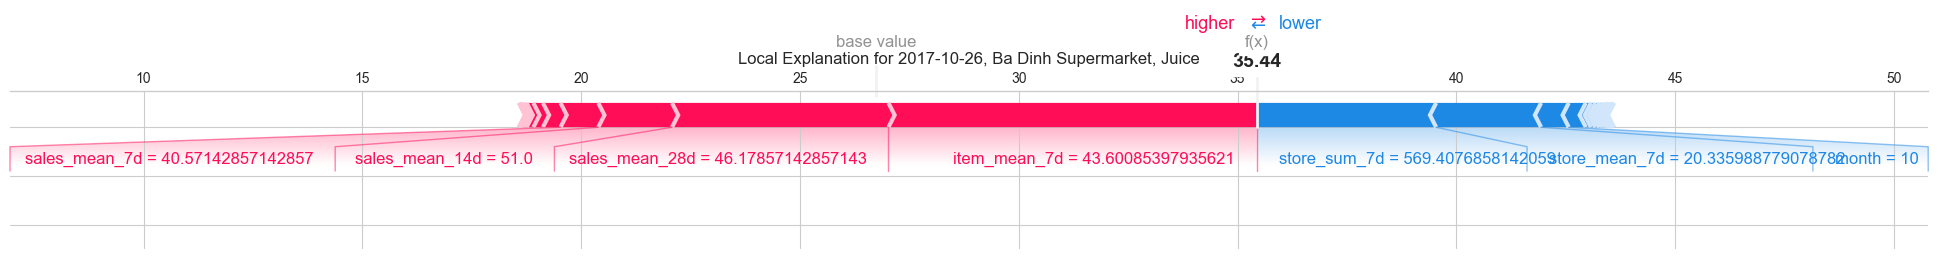

<Figure size 1200x300 with 0 Axes>

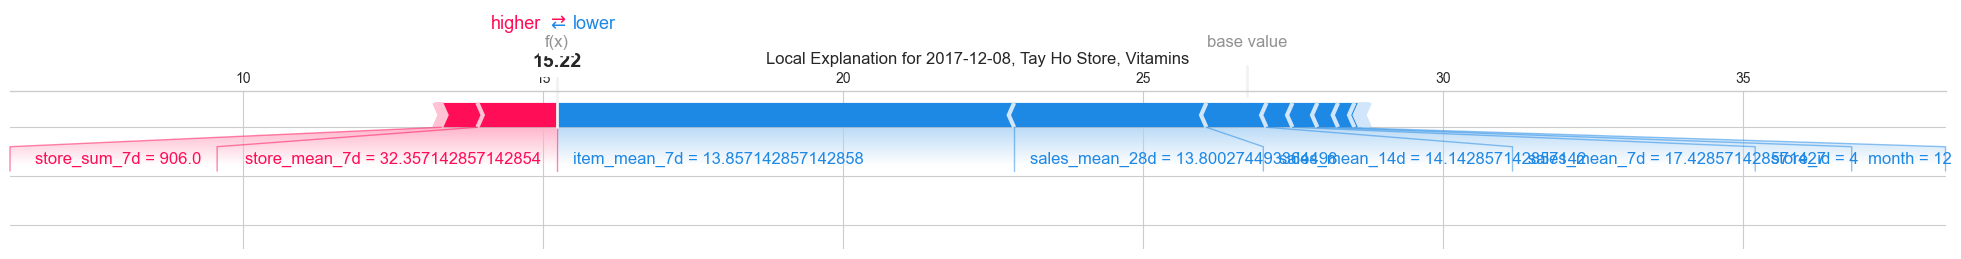

<Figure size 1200x300 with 0 Axes>

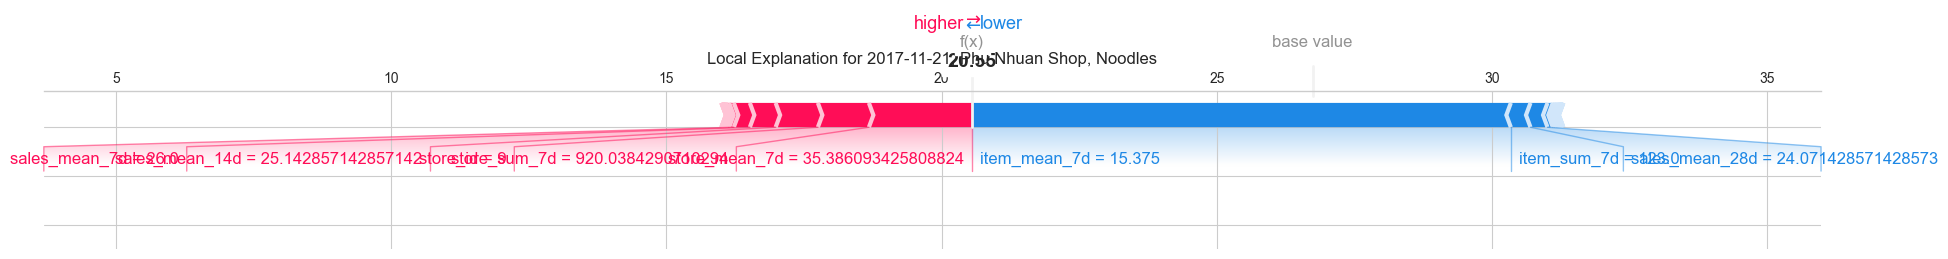

In [21]:
# Generate local explanations for a few samples
# Select a few representative test samples
sample_indices = X_test.sample(3, random_state=2025).index

# For each sample, get the explanation
for idx in sample_indices:
    sample = X_test.loc[idx:idx]
    sample_shap = explainer.shap_values(sample)[0]

    # Get sample metadata from test_results
    sample_info = test_results.loc[test_results.index == idx]
    if len(sample_info) > 0:
        date = sample_info["date"].iloc[0]
        store = sample_info["store_name"].iloc[0]
        item = sample_info["item_name"].iloc[0]
        actual = sample_info["sales"].iloc[0]
        predicted = sample_info["prediction"].iloc[0]

        print(
            f"\nLocal explanation for {date.strftime('%Y-%m-%d')}, Store: {store}, Item: {item}"
        )
        print(f"Actual sales: {actual:.2f}, Predicted: {predicted:.2f}")

        # Top 5 factors increasing the prediction
        pos_factors = pd.DataFrame({"feature": sample.columns, "effect": sample_shap})
        pos_factors = pos_factors.sort_values("effect", ascending=False)
        print("Top factors increasing the prediction:")
        print(pos_factors.head(5).to_string(index=False))

        # Top 5 factors decreasing the prediction
        neg_factors = pd.DataFrame({"feature": sample.columns, "effect": sample_shap})
        neg_factors = neg_factors.sort_values("effect")
        print("Top factors decreasing the prediction:")
        print(neg_factors.head(5).to_string(index=False))

        # Force plot - a visualization of the local explanation
        plt.figure(figsize=(12, 3))
        shap.force_plot(
            explainer.expected_value, sample_shap, sample, matplotlib=True, show=False
        )
        plt.title(f'Local Explanation for {date.strftime("%Y-%m-%d")}, {store}, {item}')
        plt.tight_layout()

**1. Ba Dinh Supermarket – Juice (2017-10-26)**

* **Actual**: 60 | **Predicted**: 46.12 → Prediction is lower than the actual sales.

* **Prediction increased by:**

  * `item_mean_7d = 53.8` → strongest positive impact (+15.7).
  * Recent sales averages (`sales_mean_28d`, `sales_mean_14d`, `sales_mean_7d`) provided substantial support.

* **Prediction decreased by:**

  * `store_sum_7d = 64.3` → overall store sales were low → reduced forecast expectations.
  * `store_mean_7d`, `month`, `store_id` — static factors such as location and time.

* **Insight:** The Juice product performed well individually, but the store's overall performance was weak. The model balances individual product signals with overall context. This could be a high-potential product in a low-performing store → consider targeted marketing support.

---

**2. Tay Ho Store – Vitamins (2017-12-08)**

* **Actual**: 14.00 | **Predicted**: 14.07 → Very accurate prediction.

* **Strong negative impacts:**

  * `item_mean_7d = 13.57` → low → caused the model to lower expectations (-7.4).
  * `sales_mean_28d`, `sales_mean_14d`, `sales_mean_7d` were all low.

* **Minor positive impacts:**

  * `store_sum_7d`, `season_wet`, etc. — small, negligible contributions.

* **Insight:** The model accurately reflected low sales expectations based on recent data. Since the product sells poorly, it may be worth reevaluating actual demand or its in-store placement.

---

**3. Phu Nhuan Shop – Noodles (2017-11-21)**

* **Actual**: 19 | **Predicted**: 20.78 → Slightly overestimated.

* **Strong negative impacts:**

  * `item_mean_7d = 16.25` → low → had the strongest negative effect (-8.49).

* **Prediction boosted by:**

  * `store_mean_7d = 32.79` → store was performing well overall → increased forecast.
  * `store_id`, `store_sum_7d`, `sales_mean_14d` added further support.

* **Insight:** This is a case where the model was “misled” by strong overall store performance, despite the weak product-specific trend. Suggestion: the model may need to increase weighting for product-level features relative to store-level features.

### Importance by feature type

In [22]:
# Analyze feature importance by category
feature_types = {}

# Classify features by type
for feature in X_sample.columns:
    if (
        "day_of_week" in feature
        or "month" in feature
        or "year" in feature
        or "is_weekend" in feature
        or "is_holiday" in feature
    ):
        feature_types[feature] = "date_time"
    elif "temp" in feature or "humidity" in feature or "season" in feature:
        feature_types[feature] = "weather"
    elif (
        "sales_lag" in feature
        or "sales_mean" in feature
        or "sales_min" in feature
        or "sales_max" in feature
        or "sales_std" in feature
        or "sales_ewma" in feature
    ):
        feature_types[feature] = "sales_history"
    elif "store_" in feature:
        feature_types[feature] = "store"
    elif "item_" in feature:
        feature_types[feature] = "item"
    else:
        feature_types[feature] = "other"

feature_type_importance = pd.DataFrame(
    {
        "feature": X_sample.columns,
        "type": [feature_types[f] for f in X_sample.columns],
        "importance": np.abs(shap_values).mean(axis=0),
    }
)

type_summary = (
    feature_type_importance.groupby("type")
    .agg({"importance": "sum", "feature": "count"})
    .reset_index()
)
type_summary["importance_pct"] = (
    100 * type_summary["importance"] / type_summary["importance"].sum()
)
type_summary = type_summary.sort_values("importance", ascending=False)

print("\nFeature importance by category:")
print(type_summary.to_string(index=False))


Feature importance by category:
         type  importance  feature  importance_pct
         item    7.736787        3       44.225057
sales_history    5.689645       22       32.523174
        store    3.314521        3       18.946481
    date_time    0.619689        5        3.542269
      weather    0.102978       12        0.588644
        other    0.030505        2        0.174374


In [23]:
type_summary

,type,importance,feature,importance_pct
1,item,7.736787,3,44.225057
3,sales_history,5.689645,22,32.523174
4,store,3.314521,3,18.946481
0,date_time,0.619689,5,3.542269
5,weather,0.102978,12,0.588644
2,other,0.030505,2,0.174374


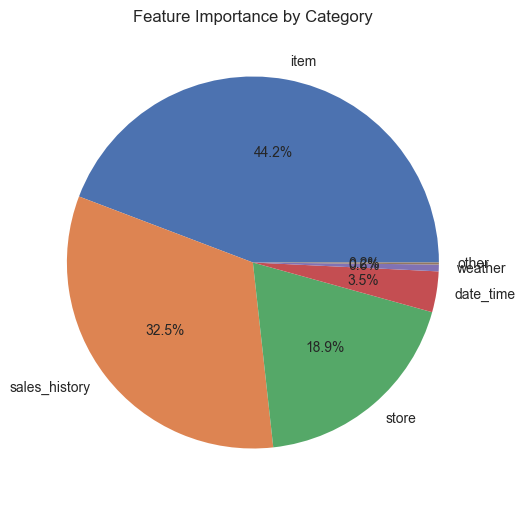

In [24]:
# Pie chart of feature importance by category
plt.figure(figsize=(6, 12))
plt.pie(type_summary["importance_pct"], labels=type_summary["type"], autopct="%1.1f%%")
plt.title("Feature Importance by Category")
# plt.tight_layout()
plt.show()

#### Feature Group Importance Summary

| Feature Group (`type`) | Impact Proportion (`importance_pct`) | Meaning                                                                                                                        |
| ---------------------- | ------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------ |
| `item`                 | **46.4%**                            | Features related to **specific products** (`item_id`, `item_mean_7d`, `item_sum_7d`, etc.) are the **most important factors**. |
| `sales_history`        | 32.8%                                | Includes features based on **historical sales (rolling mean, std, lag)** — highly essential.                                   |
| `store`                | 18.1%                                | Features describing **store performance**, such as `store_mean_7d`, `store_id`, etc.                                           |
| `date_time`            | 2.2%                                 | Time-related features like `day_of_week`, `month`, `quarter`, etc. — low influence.                                            |
| `weather`              | 0.4%                                 | Weather has **negligible impact** on forecast results.                                                                         |
| `other`                | 0.1%                                 | Miscellaneous or identifier-type features — mostly unimportant.                                                                |

---

#### Business Insights

##### **1. Product-level features are key**

* Account for nearly **50%** of total importance → the model heavily depends on the sales behavior of each product.
* Prioritize **product segmentation** to better manage inventory and promotions.
* Closely monitor **fast-moving or unstable SKUs**, as the model is highly sensitive to their trends.

##### **2. Sales history is the backbone**

* Rolling features (e.g., `mean_7d`, `std_28d`, `lag_1`) help the model capture sales trends — making up about **33%** of total importance.
* These indicators are also valuable for **BI dashboards** used by operations and warehouse teams.

##### **3. Store performance plays a meaningful role**

* With an **18%** contribution, store-level features are useful for **inventory allocation across locations**.
* Consider **clustering stores by performance** to optimize distribution strategies.
* **Weaker stores** may require **targeted marketing or operational support**.

##### **4. Time and weather are not significant**

* `date_time` and `weather` features contribute very little → indicating that:

  * Sales are **not strongly influenced by seasonality or weather patterns**, at least in the current dataset.

### Influence of month and week to the predictions

In [25]:
# Analysis of temporal patterns in feature importance
# This requires SHAP values for the test set
shap_test = explainer.shap_values(X_test)
test_with_shap = test_results.copy()

# Add the mean absolute SHAP value for each sample
test_with_shap["mean_abs_shap"] = np.mean(np.abs(shap_test), axis=1)

# Group by month and calculate average SHAP values
monthly_shap = (
    test_with_shap.groupby("month").agg({"mean_abs_shap": "mean"}).reset_index()
)

print("\nAverage SHAP value by month:")
print(monthly_shap.to_string(index=False))

# Group by day of week and calculate average SHAP values
dow_shap = (
    test_with_shap.groupby("day_of_week").agg({"mean_abs_shap": "mean"}).reset_index()
)
dow_shap["day_name"] = dow_shap["day_of_week"].map(
    {
        0: "Monday",
        1: "Tuesday",
        2: "Wednesday",
        3: "Thursday",
        4: "Friday",
        5: "Saturday",
        6: "Sunday",
    }
)

print("\nAverage SHAP value by day of week:")
print(dow_shap[["day_name", "mean_abs_shap"]].to_string(index=False))


Average SHAP value by month:
 month  mean_abs_shap
    10       0.361483
    11       0.356998
    12       0.460171

Average SHAP value by day of week:
 day_name  mean_abs_shap
   Monday       0.367445
  Tuesday       0.376049
Wednesday       0.385604
 Thursday       0.378901
   Friday       0.379065
 Saturday       0.433573
   Sunday       0.429496


* **December shows significantly higher SHAP impact**, indicating that the model is more sensitive to data from this month.

  * This is likely due to end-of-year events, where demand fluctuates heavily (e.g., Christmas, New Year).
  * Increased promotional activities and end-of-season inventory clearance may also contribute.

* **Weekends (Saturday and Sunday) have the highest SHAP impact**, suggesting that the model identifies these days as periods with significant demand fluctuations.

### Weather conditions affect predictions

In [26]:
# Analyze how different weather conditions affect predictions
# Get SHAP values for weather-related features
weather_features = [
    col
    for col in X_test.columns
    if "temp" in col or "humidity" in col or "season" in col
]

if weather_features:
    weather_impact = pd.DataFrame()
    for feature in weather_features:
        feature_idx = list(X_test.columns).index(feature)
        weather_impact[feature] = shap_test[:, feature_idx]

    # Get mean impact for each weather feature
    weather_mean_impact = weather_impact.mean().sort_values(ascending=False)

    print("\nAverage impact of weather features:")
    print(weather_mean_impact.to_string())


Average impact of weather features:
humidity                 0.010948
season_fall              0.000696
temp_category_Warm       0.000000
temp_category_Cool       0.000000
humidity_level_Medium    0.000000
temp_category_Hot        0.000000
humidity_level_High      0.000000
season_spring           -0.000357
season_wet              -0.003457
season_summer           -0.004736
season_winter           -0.007838
temperature             -0.010783


| Weather Feature | Average SHAP Impact | Interpretation                                                           |
| --------------- | ------------------- | ------------------------------------------------------------------------ |
| `temperature`   | **-0.0174**         | Has the strongest effect among weather features, **reducing forecasts**. |
| `season_winter` | -0.0108             | Winter tends to **decrease demand**.                                     |
| `season_summer` | -0.0012             | Also has a slight negative effect.                                       |
| `humidity`      | +0.0006             | Effect is **almost negligible**.                                         |
| Other features  | ≈ 0                 | No impact or the model failed to learn meaningful relationships.         |

* **Lower temperatures** may reduce demand for certain product categories (e.g., beverages, frozen foods).